In [1]:
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
import json

In [2]:
def json_to_df(json_data):
    flatten_list = []
    for item in json_data:
        item_meta = item.copy()
        del item_meta["arbitrages"]
        for arb in item["arbitrages"]:
            new_item = item_meta.copy()
            new_item.update(arb)
            flatten_list.append(
                new_item
            )
    return pd.DataFrame(flatten_list)

def json_to_meta_df(json_data):
    return pd.DataFrame(json_data)

## BF Runtime vs Number of Tokens

In [3]:
bf_df = pd.DataFrame()
bf_meta = pd.DataFrame()
for i in range(3, 16):
    with open(f"data/bf_test_{i}_2.json") as f:
        bf_json_data = json.load(f)
        bf_df = pd.concat(
            [
                bf_df,
                json_to_df(bf_json_data)
            ]
        )
        bf_meta = pd.concat(
            [
                bf_meta,
                json_to_meta_df(bf_json_data)
            ]
        )
bf_df = bf_df.assign(
    eth_return_precost = lambda df: df["u_eth"].mul(df["return_precost"])
)

In [4]:
naive_df = pd.DataFrame()
naive_meta = pd.DataFrame()
for i in range(3, 10):
    with open(f"data/naive_test_{i}_1.json") as f:
        naive_json_data = json.load(f)
        naive_df = pd.concat(
            [
                naive_df,
                json_to_df(naive_json_data)
            ]
        )
        naive_meta = pd.concat(
            [
                naive_meta,
                json_to_meta_df(naive_json_data)
            ]
        )
naive = naive_df.assign(
    eth_return_precost = lambda df: df["u_eth"].mul(df["return_precost"])
)

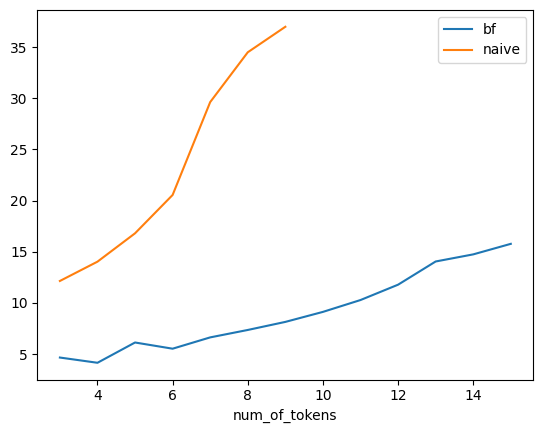

In [5]:
bf_meta.groupby(["num_of_tokens"])["time"].mean().plot()
naive_meta.groupby(["num_of_tokens"])["time"].mean().plot()
plt.legend(["bf", "naive"])

<Axes: >

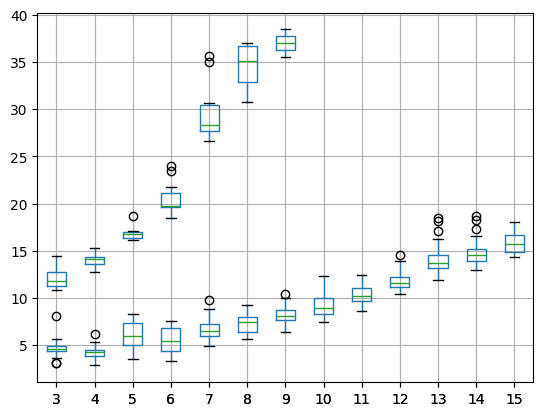

In [6]:

naive_meta.pivot(
    index = "block_number",
    columns = "num_of_tokens",
    values = "time"
).assign(
    **{
        str(i): np.nan
        for i in range(10, 16)
    }
).boxplot()
bf_meta.pivot(
    index = "block_number",
    columns = "num_of_tokens",
    values = "time"
).boxplot()

In [7]:
naive_time_df = naive_meta.assign(
    ln_num_of_tokens = lambda df: df["num_of_tokens"].pipe(np.log)
)

OLS(
    naive_time_df["time"],
    add_constant(naive_time_df["num_of_tokens"].pipe(lambda x: np.power(x, 2)))
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     668.4
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           7.08e-34
Time:                        17:42:08   Log-Likelihood:                -135.96
No. Observations:                  61   AIC:                             275.9
Df Residuals:                      59   BIC:                             280.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.6707      0.569     13.491      0.000       6.533       8.809
num_of_tokens     0.4040      0.016     25.854      0.000       0.373       0.435
==============================================================================
Omnibus:                       22.635   Durbin-Watson:                   0.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.780
Skew:                           1.225   Prob(JB):                     1.40e-09
Kurtosis:                       6.169   Cond. No.                         70.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
bf_time_df = bf_meta.assign(
    ln_num_of_tokens = lambda df: df["num_of_tokens"].pipe(np.log)
)

OLS(
    bf_time_df["time"],
    add_constant(bf_time_df["num_of_tokens"].pipe(lambda x: np.power(x, 2)))
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     5671.
Date:                Mon, 01 Apr 2024   Prob (F-statistic):          1.42e-285
Time:                        17:42:08   Log-Likelihood:                -829.55
No. Observations:                 533   AIC:                             1663.
Df Residuals:                     531   BIC:                             1672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9053      0.085     45.867      0.000       3.738       4.073
num_of_tokens     0.0548      0.001     75.307      0.000       0.053       0.056
==============================================================================
Omnibus:                       71.697   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.260
Skew:                           0.845   Prob(JB):                     2.09e-26
Kurtosis:                       4.571   Cond. No.                         200.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='block_number'>

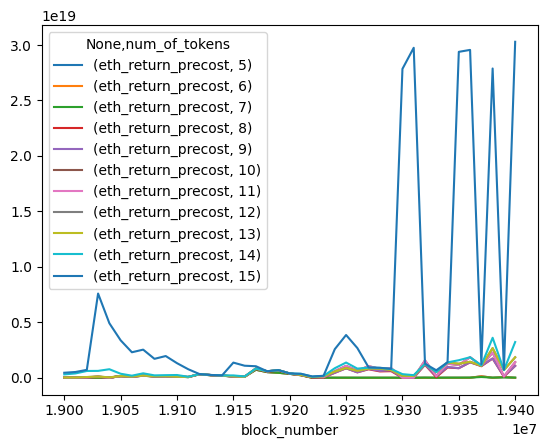

In [9]:
bf_df.groupby(["num_of_tokens", "block_number"])["eth_return_precost"].sum().reset_index().pivot_table(
    index = "block_number", columns = "num_of_tokens"
).fillna(0).plot()


## Analysis of U

In [10]:
u_eth_space = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
num_of_tokens_space = list(range(3, 13))
filenames_bf = [
    f"bf_test_{num_of_tokens}_{u_eth}.json"
    for num_of_tokens in num_of_tokens_space
    for u_eth in u_eth_space
]

filenames_naive = [
    f"naive_test_{num_of_tokens}_1.json"
    for num_of_tokens in range(3, 10)
]